# Purpose:

From analyzing the data-clustering-structure by vizualisation with UMAP-projections, we found sBERT to be promissing. <br>
Here we compare XGBoost and LogisticRegression on sBert alone and on sBert + UMAP as preparatory steps. <br>
SBERT alone is clearly superior to SBERT+UMAP: <br>


## Load Data:

In [1]:
import umap.umap_ as umap
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer


# Load Data:
df = pd.read_csv("../data/sachkonto_positionstexte.csv")
X = df["Positionstext"].tolist()
y = df["Sachkonto"].tolist()
print(df.head(3))

   Sachkonto Sachkontobeschreibung                       Positionstext
0     400000         Waren-Eingang  Wareneingang Lieferung Müller GmbH
1     400000         Waren-Eingang            Rechnung über Bürobedarf
2     400000         Waren-Eingang             Lieferung Druckerpapier


### Classification using ONLY  sBERT transformation as data-preparation step

#### Train-Test Split:

In [2]:
# proj = get_sbert_umap(documents) <- we cannot use the function here, because the umap-manifold will be build on all data in this case, which is information-leakage.

from sklearn.model_selection import train_test_split

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

#### Encode with sBert:

In [3]:
# encode with sBert
model = SentenceTransformer('all-MiniLM-L6-v2')
X_train = model.encode(X_train)
X_test = model.encode(X_test)

# check: embedding dimension should be 384
X_train.shape[1]

c:\Users\Hal9\anaconda3\envs\umap-test\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


384

### XGB Classifier on sBert without UMAP:

In [4]:
from xgboost import XGBClassifier

clf = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
clf.fit(X_train, y_train)

# Prediction
y_pred = clf.predict(X_test)

# Get clear labels:
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

c:\Users\Hal9\anaconda3\envs\umap-test\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
# Evaluation
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))

Classification Report:
              precision    recall  f1-score   support

      400000       0.67      0.50      0.57         4
      440000       0.75      0.75      0.75         4
      480000       0.25      0.25      0.25         4
      481000       0.33      0.50      0.40         4
      490000       0.12      0.25      0.17         4
      500000       0.50      0.25      0.33         4
      510000       1.00      0.50      0.67         4
      520000       0.67      1.00      0.80         4
      530000       0.33      0.25      0.29         4
      540000       1.00      0.50      0.67         4

    accuracy                           0.48        40
   macro avg       0.56      0.47      0.49        40
weighted avg       0.56      0.47      0.49        40



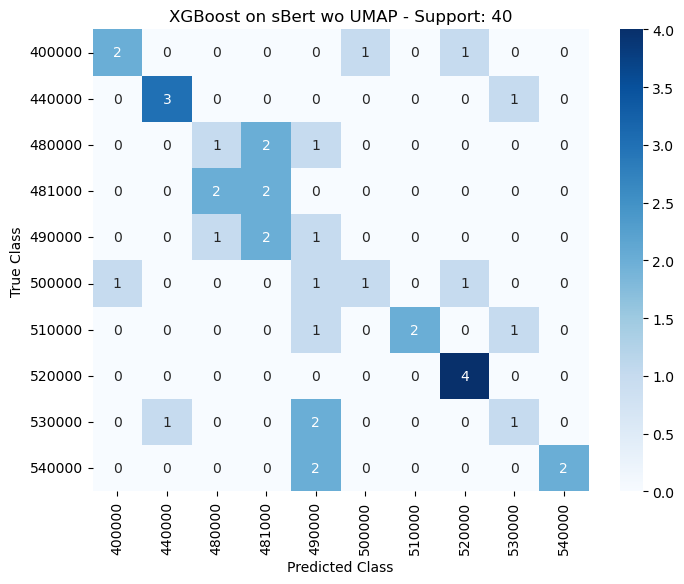

In [6]:
from utils import plot_confusion_matrix

tick_labels = np.unique(y).astype(str)

plot_confusion_matrix(y_test=y_test, y_pred=y_pred, x_labels=tick_labels, y_labels=tick_labels, header_text="XGBoost on sBert wo UMAP")

### Logistic Regression Classifier on sBert without UMAP:

In [7]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(random_state=42)
log_clf.fit(X_train, y_train)
y_pred = log_clf.predict(X_test)

# Get clear labels:
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

In [8]:
# Evaluation
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))

Classification Report:
              precision    recall  f1-score   support

      400000       0.00      0.00      0.00         4
      440000       1.00      0.75      0.86         4
      480000       0.60      0.75      0.67         4
      481000       1.00      0.75      0.86         4
      490000       0.33      0.50      0.40         4
      500000       0.57      1.00      0.73         4
      510000       1.00      0.50      0.67         4
      520000       0.80      1.00      0.89         4
      530000       0.50      0.50      0.50         4
      540000       0.75      0.75      0.75         4

    accuracy                           0.65        40
   macro avg       0.66      0.65      0.63        40
weighted avg       0.66      0.65      0.63        40



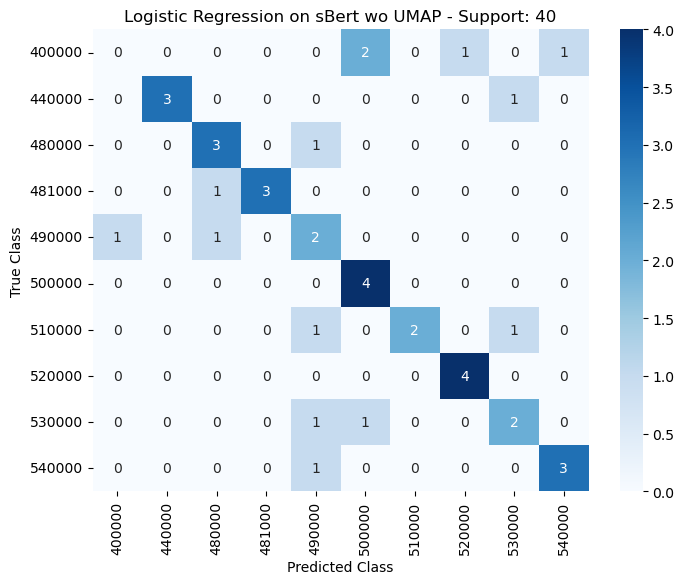

In [9]:
from utils import plot_confusion_matrix

tick_labels = np.unique(y).astype(str)

plot_confusion_matrix(y_test=y_test, y_pred=y_pred, x_labels=tick_labels, y_labels=tick_labels, header_text="Logistic Regression on sBert wo UMAP")

### Classification using sBERT and UMAP transformation as data-preparation step

### XBGClassifier on sBert+UMAP:

Apply SentenceTransformer (sBert) and UMAP to the Documents

#### Comment: <br>
 We cannot use the function "get_sbert_umap(documents)" here, because the umap-manifold will be build on all data in this case, which would constitute data-leakage. Instead we have to build the manifold on the training data and apply it to training and test data.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(X)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(embeddings, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
umap_projector = umap.UMAP(random_state=42)
X_train = umap_projector.fit_transform(X_train)
X_test = umap_projector.transform(X_test)

c:\Users\Hal9\anaconda3\envs\umap-test\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\Hal9\anaconda3\envs\umap-test\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [11]:
from xgboost import XGBClassifier

clf = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
clf.fit(X_train, y_train)

# Prediction
y_pred = clf.predict(X_test)

# Get clear labels:
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

In [12]:
# Evaluation
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))

Classification Report:
              precision    recall  f1-score   support

      400000       0.00      0.00      0.00         4
      440000       0.00      0.00      0.00         4
      480000       0.40      0.50      0.44         4
      481000       0.50      0.75      0.60         4
      490000       1.00      0.25      0.40         4
      500000       0.25      0.25      0.25         4
      510000       0.29      0.50      0.36         4
      520000       0.33      0.25      0.29         4
      530000       0.33      0.50      0.40         4
      540000       0.50      0.25      0.33         4

    accuracy                           0.33        40
   macro avg       0.36      0.33      0.31        40
weighted avg       0.36      0.33      0.31        40



c:\Users\Hal9\anaconda3\envs\umap-test\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Hal9\anaconda3\envs\umap-test\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Hal9\anaconda3\envs\umap-test\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


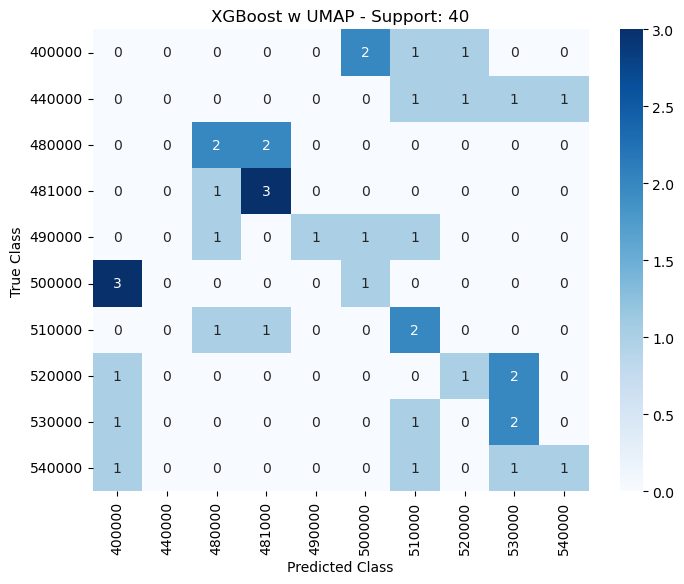

In [13]:
from utils import plot_confusion_matrix

tick_labels = np.unique(y).astype(str)

plot_confusion_matrix(y_test=y_test, y_pred=y_pred, x_labels=tick_labels, y_labels=tick_labels, header_text="XGBoost w UMAP")

### LogisticRegression on sBert+UMAP:

In [14]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(random_state=42)
log_clf.fit(X_train, y_train)
y_pred = log_clf.predict(X_test)

# Get clear labels:
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

c:\Users\Hal9\anaconda3\envs\umap-test\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))

Classification Report:
              precision    recall  f1-score   support

      400000       0.40      0.50      0.44         4
      440000       0.00      0.00      0.00         4
      480000       0.67      0.50      0.57         4
      481000       0.50      1.00      0.67         4
      490000       0.00      0.00      0.00         4
      500000       0.00      0.00      0.00         4
      510000       0.29      0.50      0.36         4
      520000       0.20      0.25      0.22         4
      530000       0.25      0.50      0.33         4
      540000       0.00      0.00      0.00         4

    accuracy                           0.33        40
   macro avg       0.23      0.33      0.26        40
weighted avg       0.23      0.33      0.26        40



c:\Users\Hal9\anaconda3\envs\umap-test\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Hal9\anaconda3\envs\umap-test\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Hal9\anaconda3\envs\umap-test\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


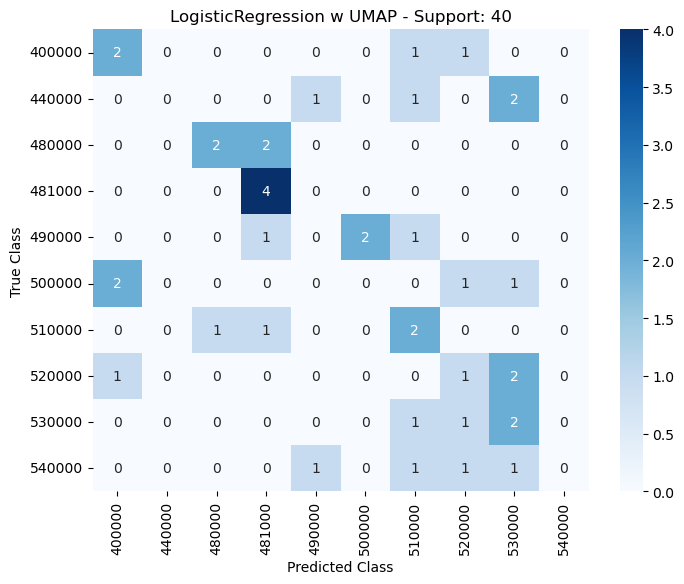

In [16]:
from utils import plot_confusion_matrix

tick_labels = np.unique(y).astype(str)

plot_confusion_matrix(y_test=y_test_labels, y_pred=y_pred_labels, x_labels=tick_labels, y_labels=tick_labels, header_text="LogisticRegression w UMAP")

#### SUMMARY:

Obviously using UMAP projection as a preparation step, makes things worse. <br>
<br>
The reason for this is probably the rather "harsh" projection of SBERT's 384 dimensions down to 2 by UMAP.<br>
Using sBert without UMAP shows a considerable improvement for both models:

|Accuracy           |sBert & UMAP |BERT     |
|-------------------|-------------|---------|
|XBG                |0.33         |0.48     |
|Logistic Regression|0.33         |0.65     |

## PCA auf SBERT embeddings: Accuracy vs Anzahl Hauptkomponenten

In [17]:
# load data once more to be sure...

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sentence_transformers import SentenceTransformer

# Load Data:
df = pd.read_csv("../data/sachkonto_positionstexte.csv")
X = df["Positionstext"].tolist()
y = df["Sachkonto"].tolist()
print(df.head(3))

   Sachkonto Sachkontobeschreibung                       Positionstext
0     400000         Waren-Eingang  Wareneingang Lieferung Müller GmbH
1     400000         Waren-Eingang            Rechnung über Bürobedarf
2     400000         Waren-Eingang             Lieferung Druckerpapier


c:\Users\Hal9\anaconda3\envs\umap-test\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


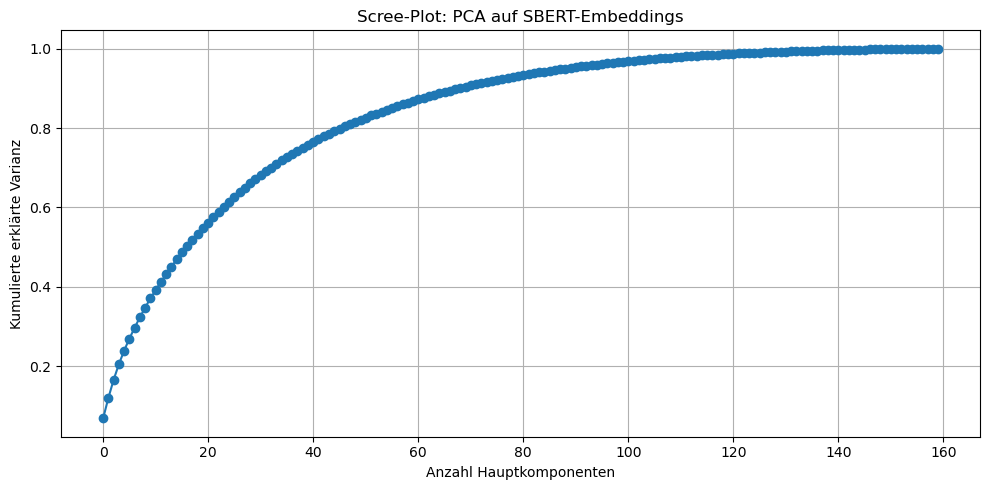

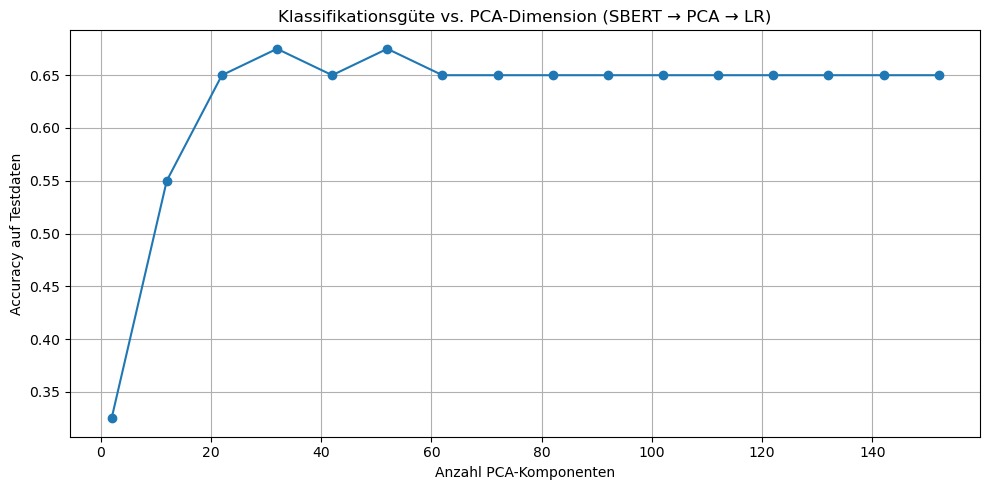

In [18]:
# Labels kodieren:
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # y = zugehörige Sachkonten

# Train/Test-Split:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

 # SBERT-Embeddings:
model = SentenceTransformer('all-MiniLM-L6-v2')
X_train = model.encode(X_train)  # X = Liste der Texte
X_test = model.encode(X_test)

# Explained Variance / Scree-Plot:
n_pca_max = min(X_train.shape[0], X_train.shape[1])  # maximal sinnvolle PCA-Dimension: Minimum #Zeilen und #Spalten
pca_full = PCA(n_components=n_pca_max)
pca_full.fit(X_train)

explained_var_ratio = pca_full.explained_variance_ratio_
cum_explained = np.cumsum(explained_var_ratio)

plt.figure(figsize=(10, 5))
plt.plot(cum_explained, marker='o')
plt.xlabel("Anzahl Hauptkomponenten")
plt.ylabel("Kumulierte erklärte Varianz")
plt.title("Scree-Plot: PCA auf SBERT-Embeddings")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Accuracy vs. PCA-Komponenten
component_range = list(range(2, n_pca_max + 1, 10))
accuracies = []

for n in component_range:
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# 6. Plot: Accuracy vs. PCA-Dimension
plt.figure(figsize=(10, 5))
plt.plot(component_range, accuracies, marker='o')
plt.xlabel("Anzahl PCA-Komponenten")
plt.ylabel("Accuracy auf Testdaten")
plt.title("Klassifikationsgüte vs. PCA-Dimension (SBERT → PCA → LR)")
plt.grid(True)
plt.tight_layout()
plt.show()


### Summary:

- with 60 to 70 principal components the accuracy is stable
- with 70 principal components we have 90% of the variance explained
<br>
For data intensive applications we could use SBERT and PCA with 70 to 80 components for data reduction without losing much.

## Zu klärende Punkte:
- SBERT bei Texten ausserhalb des Korpus: was passiert? Liefert einfach encoding?
- Classifier bei Vektoren zu Texten ausserhalb des Korpus? W'keiten nutzen und nur anzeigen, wenn > 80% ?
- Funktionsweise SBERT, word2vec, doc2vec, Umap (Paper lesen)
